<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#Format" data-toc-modified-id="Format-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Format</a></span></li><li><span><a href="#IndD-sensitivity" data-toc-modified-id="IndD-sensitivity-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>IndD sensitivity</a></span><ul class="toc-item"><li><span><a href="#mpd" data-toc-modified-id="mpd-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>mpd</a></span><ul class="toc-item"><li><span><a href="#Summarizing" data-toc-modified-id="Summarizing-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>Summarizing</a></span></li></ul></li><li><span><a href="#mntd" data-toc-modified-id="mntd-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>mntd</a></span><ul class="toc-item"><li><span><a href="#Summarizing" data-toc-modified-id="Summarizing-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Summarizing</a></span></li></ul></li><li><span><a href="#Stats" data-toc-modified-id="Stats-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Stats</a></span></li><li><span><a href="#Summary-plots" data-toc-modified-id="Summary-plots-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Summary plots</a></span></li><li><span><a href="#iTOL-plotting" data-toc-modified-id="iTOL-plotting-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>iTOL plotting</a></span><ul class="toc-item"><li><span><a href="#Heatmap-of-obs.z" data-toc-modified-id="Heatmap-of-obs.z-6.5.1"><span class="toc-item-num">6.5.1&nbsp;&nbsp;</span>Heatmap of obs.z</a></span></li><li><span><a href="#Color-strip-of-clustered/even" data-toc-modified-id="Color-strip-of-clustered/even-6.5.2"><span class="toc-item-num">6.5.2&nbsp;&nbsp;</span>Color strip of clustered/even</a></span><ul class="toc-item"><li><span><a href="#mpd" data-toc-modified-id="mpd-6.5.2.1"><span class="toc-item-num">6.5.2.1&nbsp;&nbsp;</span>mpd</a></span></li><li><span><a href="#mntd" data-toc-modified-id="mntd-6.5.2.2"><span class="toc-item-num">6.5.2.2&nbsp;&nbsp;</span>mntd</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* Calculate relatedness on taxa

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/assembly/relatedness/'

# phyloseq
physeq_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/phyloseq/physeq_r5k.RDS'

# params
threads = 12
sparsity_cutoff = 0.05
n_subsample_reps = 100
model_runs = 999

# Init

In [5]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(phyloseq)

library(ape)
library(picante)

library(future)
library(future.batchtools)
library(future.apply)

source('/ebio/abt3_projects/Georg_animal_feces/code/init.R') 
source('/ebio/abt3_projects/Georg_animal_feces/code/itol.R') 

## Functions

In [6]:
#' determining whether evenness or clustering for most subsample reps
even_or_clust = function(x, thresh=0.95){
    x = x[!is.na(x)]
    y = 'NA'
    if(length(x) < 1){
        y = 'NA'
    } else 
    if(sum(x == 'even') / length(x) > thresh){
        y = 'even'
    } else
    if(sum(x == 'clustered') / length(x) > thresh){
        y = 'clustered'
    } 
    return(y)
}

# Load

In [7]:
physeq = readRDS(physeq_file)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 30290 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 30290 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 30290 tips and 29752 internal nodes ]

# Format

In [8]:
# sparsity cutoff
physeq = physeq %>%
    filter_taxa(function(x) sum(x > 0) / length(x) > sparsity_cutoff, TRUE) 
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 408 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 408 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 408 tips and 406 internal nodes ]

In [9]:
# coverting to binomial
physeq = physeq %>%
    transform_sample_counts(function(x) ifelse(x > 0, 1, 0)) 
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 408 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 408 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 408 tips and 406 internal nodes ]

In [12]:
# convert to comm table
comm = physeq %>%
    otu_table %>%
    as.matrix %>% 
    t %>%
    as.data.frame 

comm %>% dfhead

[1] 213 408


,368bd5c2255f3a5ce0fef06ca6de1d04,779324e5648460c5a67e577c45131b42,b918d185ee89a0b33d821ee766d76eb3,d3d51a026150fca2a3400c59a6b311cb,160c9184bbfc1e5766c508c7bdafa19f,f0f035365a85490145f397bf218afbab,7282e9b6f799208576024a35f02caa47,0e1de44ae4fcc0968e549457277b4fb1,ba6caaf355af10bdcdcc625e4f99073e,13fabb2c42c260bd77b4358f429eba6c,⋯,1b4755614ecbdd82a79e77eae5143239,d855008e1da5c9a5c3ba81d21b6ea272,9dfddc1c446e84f8ff7f5a7332e70e3a,6f8aa3da4c4fa50cd74ad28f489adefc,22930923dace53039f5eb90d94ceca1e,88f04219eab15eae30870064288e9a5f,17dac3c523ec0b232c6a9c711d69968f,98300b47154d82766e5d100558d1ba09,958c1eeaa690e27ee970154111e25192,d78e13cf379c4409b2bc382ffb62f962
X1.Eurasian.Beaver,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
X101.Horse,0,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
X102.Kulan,0,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [13]:
# 16S tree
microbe_tree = physeq %>% phy_tree
microbe_tree_d = microbe_tree %>% cophenetic
microbe_tree


Phylogenetic tree with 408 tips and 406 internal nodes.

Tip labels:
	368bd5c2255f3a5ce0fef06ca6de1d04, 779324e5648460c5a67e577c45131b42, b918d185ee89a0b33d821ee766d76eb3, d3d51a026150fca2a3400c59a6b311cb, 160c9184bbfc1e5766c508c7bdafa19f, f0f035365a85490145f397bf218afbab, ...
Node labels:
	0.435, 0.627, 0.783, 0.889, 0.861, 0.895, ...

Rooted; includes branch lengths.

In [14]:
# metadata
metadata = physeq %>%
    sample_data %>%
    as.matrix %>%
    as.data.frame %>%
    mutate(Sample = rownames(.)) %>%
    dplyr::select(Sample, scientific_name, class, order, family, genus, diet)

metadata %>% dfhead

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

[1] 213   7


Sample,scientific_name,class,order,family,genus,diet
X1.Eurasian.Beaver,Castor_fiber,Mammalia,Rodentia,Castoridae,Castor,herbivore
X101.Horse,Equus_caballus,Mammalia,Perissodactyla,Equidae,Equus,herbivore
X102.Kulan,Equus_hemionus,Mammalia,Perissodactyla,Equidae,Equus,herbivore


In [15]:
# taxonomy
blacklist = c('', 'unclassified', 'uncultured', 'unidentified', 'Incertae Sedis') 
tax = physeq %>%
    tax_table %>%
    as.matrix %>%
    as.data.frame %>%
    mutate(OTU = rownames(.),
           Genus = Genus %>% as.character,
           Family = Family %>% as.character,
           Genus = ifelse(Genus %in% blacklist, gsub('$', '_unclassified', Family), Genus)) %>%
    dplyr::select(-Species)

tax %>% dfhead

[1] 408   7


Domain,Phylum,Class,Order,Family,Genus,OTU
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,368bd5c2255f3a5ce0fef06ca6de1d04
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,779324e5648460c5a67e577c45131b42
Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,b918d185ee89a0b33d821ee766d76eb3


# IndD sensitivity

* 100 subsamples of 1 sample per species

In [16]:
comm_subsample = function(rep, comm, metadata){
    to_keep = metadata %>% 
        group_by(scientific_name) %>% 
        sample_n(1) %>%
        .$Sample %>% as.character 
    return(comm[to_keep,])
}

comm_l = plyr::llply(as.list(1:n_subsample_reps), 
                     function(x) comm_subsample(x, comm, metadata),
                     .parallel=FALSE)

# number of samples per subset
lapply(comm_l, nrow) %>% unlist %>% summary %>% print
comm_l %>% length %>% print

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    128     128     128     128     128     128 
[1] 100


## mpd

In [17]:
#' function for running mpd on each subset 
mpd_each = function(rep, comm_l, tree_d, null.model = "taxa.labels", 
                    abundance.weighted = FALSE, runs = 99){
    ses_mpd_res = ses.mpd(comm_l[[rep]], tree_d, 
                          null.model = null.model, 
                          abundance.weighted = abundance.weighted, 
                          runs = runs)
    ses_mpd_res$subsample_rep = rep
    ses_mpd_res$Sample = rownames(ses_mpd_res)
    return(ses_mpd_res)
}

In [12]:
#-- WARNING: SLOW --#
# cluster resources
resources = list(h_rt = '8:00:00',
                 h_vmem = '8G',
                 threads = '1',
                 conda.env = 'py3_physeq_phylo', 
                 conda.path = "/ebio/abt3_projects/software/miniconda3/bin")
plan(batchtools_sge, resources=resources)

In [13]:
mpd_res = future_lapply(as.list(1:n_subsample_reps), 
                        mpd_each,
                        comm_l = comm_l, 
                        tree_d = microbe_tree_d,
                        runs = model_runs,
                        future.packages=c('picante'))

mpd_res %>% length %>% print

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vec

[1] 100


In [18]:
# saving results (file name)
mpd_file = file.path(work_dir, 'IndD_mpd_results.RDS')
mpd_file

[1] "/ebio/abt3_projects/Georg_animal_feces/data/assembly/relatedness//IndD_mpd_results.RDS"

In [15]:
# saving results 
saveRDS(mpd_res, mpd_file)
cat('File saved:', mpd_file)

File saved: /ebio/abt3_projects/Georg_animal_feces/data/assembly/relatedness//IndD_mpd_results.RDS

In [30]:
# re-loading results 
mpd_res = readRDS(mpd_file)
mpd_res %>% length %>% print

[1] 100


In [17]:
send_email('http://127.0.0.1:9705/notebooks/notebooks/16S/5_assembly/relatedness/01_IndD.ipynb')

### Summarizing

In [31]:
# convert to df
mpd_res = do.call(rbind, mpd_res) %>%
    #mutate(Sample = gsub('[0-9]+$', '', rownames(.))) %>%
    mutate(Sample = rownames(.)) %>%
    inner_join(metadata, c('Sample'))

mpd_res %>% dfhead

[1] 213  16


ntaxa,mpd.obs,mpd.rand.mean,mpd.rand.sd,mpd.obs.rank,mpd.obs.z,mpd.obs.p,runs,subsample_rep,Sample,scientific_name,class,order,family,genus,diet
5,0.4521307,0.5788607,0.17485762,262,-0.7247612,0.262,999,1,X398.Eurasian.Reed.Warbler,Acrocephalus_scirpaceus,Aves,Passeriformes,Sylviidae,Acrocephalus,omnivore
82,0.6120910,0.5847092,0.03802392,762,0.7201200,0.762,999,1,X410.Impala,Aepyceros_melampus,Mammalia,Artiodactyla,Bovidae,Aepyceros,herbivore
10,0.4408772,0.5779315,0.11499895,115,-1.1917873,0.115,999,1,X34.Mallard.Duck,Anas_platyrhynchos,Aves,Anseriformes,Anatidae,Anas,omnivore


In [32]:
# checking counts
mpd_res$subsample_rep %>% unique %>% length %>% print
mpd_res$subsample_rep %>% table %>% as.numeric %>% summary %>% print

[1] 14
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.25    2.50   15.21   12.00  128.00 


In [34]:
# summarizing results
mpd_res_s = mpd_res %>%
    mutate(
        mpd.result = NA,
        mpd.result = ifelse((mpd.obs.z > 0) & (mpd.obs.p > 0.95), 'even', mpd.result),
        mpd.result = ifelse((mpd.obs.z < 0) & (mpd.obs.p < 0.05), 'clustered', mpd.result)
        ) %>%
    group_by(scientific_name, class, order, family, genus, diet) %>%
    summarize(
        mpd.result.sum = even_or_clust(mpd.result, thresh=0.95),
        mean.mpd.obs.z = mean(mpd.obs.z, na.rm=TRUE),
        sd.mpd.obs.z = sd(mpd.obs.z, na.rm=TRUE)
        ) %>%
    ungroup() %>%
    mutate(scientific_name = scientific_name %>% reorder(-mean.mpd.obs.z))

mpd_res_s$mpd.result.sum %>% table %>% print
mpd_res_s %>% dfhead

.
clustered      even        NA 
       26         2       100 
[1] 128   9


scientific_name,class,order,family,genus,diet,mpd.result.sum,mean.mpd.obs.z,sd.mpd.obs.z
Acrocephalus_scirpaceus,Aves,Passeriformes,Sylviidae,Acrocephalus,omnivore,NA,-0.7247612,NA
Aepyceros_melampus,Mammalia,Artiodactyla,Bovidae,Aepyceros,herbivore,NA,0.7201200,NA
Anas_platyrhynchos,Aves,Anseriformes,Anatidae,Anas,omnivore,NA,-1.1917873,NA


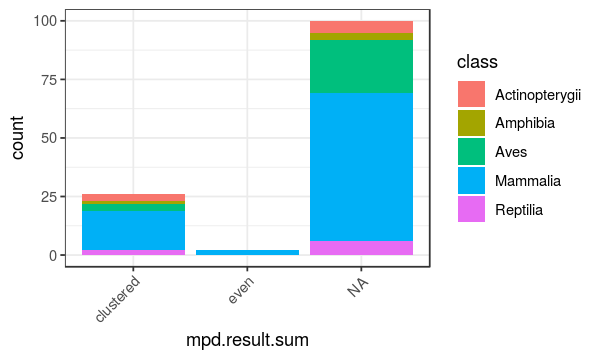

In [35]:
# plotting
p = ggplot(mpd_res_s, aes(mpd.result.sum, fill=class)) +
    geom_bar() +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

options(repr.plot.width=5, repr.plot.height=3)
plot(p)

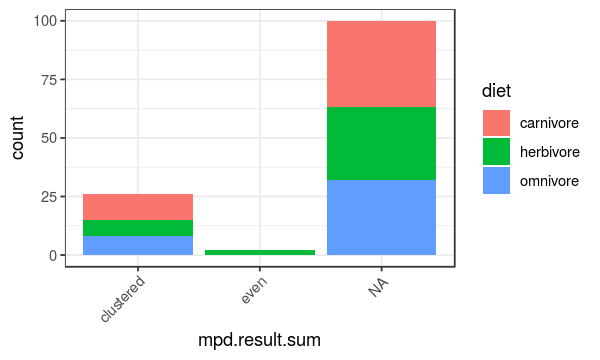

In [36]:
# plotting
p = ggplot(mpd_res_s, aes(mpd.result.sum, fill=diet)) +
    geom_bar() +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

options(repr.plot.width=5, repr.plot.height=3)
plot(p)

Warning message:
“Removed 80 rows containing missing values (geom_linerange).”Warning message:
“Removed 6 rows containing missing values (geom_point).”

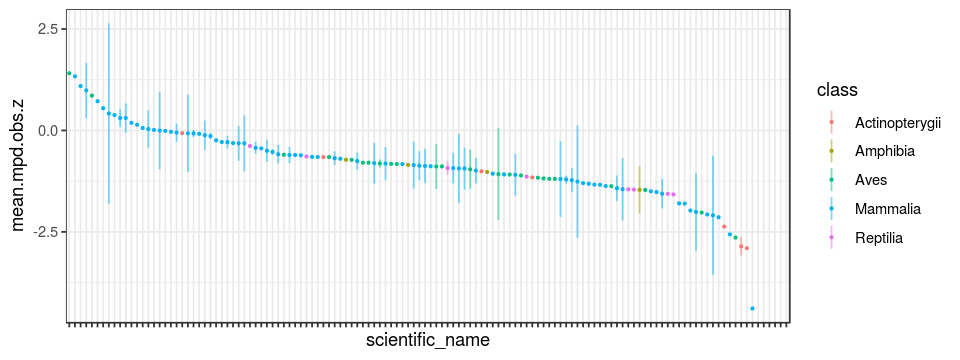

In [37]:
# plotting
p = ggplot(mpd_res_s, aes(scientific_name, mean.mpd.obs.z, color=class)) +
    geom_linerange(aes(ymin=mean.mpd.obs.z-sd.mpd.obs.z,
                       ymax=mean.mpd.obs.z+sd.mpd.obs.z), alpha=0.5) +
    geom_point(size=0.5) +
    theme_bw() +
    theme(
        axis.text.x = element_blank()
    )

options(repr.plot.width=8, repr.plot.height=3)
plot(p)

## mntd

In [38]:
#' function for running mntd on each subset 
mntd_each = function(rep, comm_l, tree_d, null.model = "taxa.labels", 
                    abundance.weighted = FALSE, runs = 99){
    ses_mntd_res = ses.mntd(comm_l[[rep]], tree_d, 
                           null.model = null.model, 
                           abundance.weighted = abundance.weighted, 
                           runs = runs)
    ses_mntd_res$subsample_rep = rep
    ses_mntd_res$Sample = rownames(ses_mntd_res)
    return(ses_mntd_res)
}

In [67]:
#-- WARNING: SLOW --#
# cluster resources
resources = list(h_rt = '8:00:00',
                 h_vmem = '8G',
                 threads = '1',
                 conda.env = 'py3_physeq_phylo', 
                 conda.path = "/ebio/abt3_projects/software/miniconda3/bin")
plan(batchtools_sge, resources=resources)

In [ ]:
mntd_res = future_lapply(as.list(1:n_subsample_reps), 
                         mntd_each,
                         comm_l = comm_l, 
                         tree_d = microbe_tree_d,
                         runs = model_runs,
                         future.packages=c('picante'))

mntd_res %>% length %>% print

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'NULL'”Warning message in is.na(x):
“is.na() applied to non-(list or vec

In [39]:
# saving results (file name)
mntd_file = file.path(work_dir, 'IndD_mntd_results.RDS')
mntd_file

[1] "/ebio/abt3_projects/Georg_animal_feces/data/assembly/relatedness//IndD_mntd_results.RDS"

In [ ]:
# saving results 
saveRDS(mntd_res, mntd_file)
cat('File saved:', mntd_file)

In [44]:
# re-loading results 
mntd_res = readRDS(mntd_file)
mntd_res %>% length %>% print

[1] 100


In [ ]:
send_email('http://127.0.0.1:9705/notebooks/notebooks/16S/5_assembly/relatedness/01_IndD.ipynb')

### Summarizing

In [45]:
# convert to df
mntd_res = do.call(rbind, mntd_res) %>%
    mutate(Sample = rownames(.)) %>%
    inner_join(metadata, c('Sample'))
mntd_res %>% dfhead

[1] 213  16


ntaxa,mntd.obs,mntd.rand.mean,mntd.rand.sd,mntd.obs.rank,mntd.obs.z,mntd.obs.p,runs,subsample_rep,Sample,scientific_name,class,order,family,genus,diet
5,0.0557149,0.3921258,0.12874717,1,-2.612958,0.001,999,1,X398.Eurasian.Reed.Warbler,Acrocephalus_scirpaceus,Aves,Passeriformes,Sylviidae,Acrocephalus,omnivore
82,0.1010151,0.1169457,0.01477561,145,-1.078168,0.145,999,1,X410.Impala,Aepyceros_melampus,Mammalia,Artiodactyla,Bovidae,Aepyceros,herbivore
10,0.1046503,0.3159598,0.08007488,3,-2.638899,0.003,999,1,X34.Mallard.Duck,Anas_platyrhynchos,Aves,Anseriformes,Anatidae,Anas,omnivore


In [47]:
# summarizing results
mntd_res_s = mntd_res %>%
    mutate(
        mntd.result = NA,
        mntd.result = ifelse((mntd.obs.z > 0) & (mntd.obs.p > 0.95), 'even', mntd.result),
        mntd.result = ifelse((mntd.obs.z < 0) & (mntd.obs.p < 0.05), 'clustered', mntd.result)
        ) %>%
    group_by(scientific_name, class, order, family, genus, diet) %>%
    summarize(
        mntd.result.sum = even_or_clust(mntd.result, thresh=0.95),
        mean.mntd.obs.z = mean(mntd.obs.z, na.rm=TRUE),
        sd.mntd.obs.z = sd(mntd.obs.z, na.rm=TRUE)
        ) %>%
    ungroup() %>%
    mutate(scientific_name = scientific_name %>% reorder(-mean.mntd.obs.z))


mntd_res_s$mntd.result.sum %>% table %>% print
mntd_res_s %>% dfhead

.
clustered      even        NA 
       59         4        65 
[1] 128   9


scientific_name,class,order,family,genus,diet,mntd.result.sum,mean.mntd.obs.z,sd.mntd.obs.z
Acrocephalus_scirpaceus,Aves,Passeriformes,Sylviidae,Acrocephalus,omnivore,clustered,-2.612958,NA
Aepyceros_melampus,Mammalia,Artiodactyla,Bovidae,Aepyceros,herbivore,NA,-1.078168,NA
Anas_platyrhynchos,Aves,Anseriformes,Anatidae,Anas,omnivore,clustered,-2.638899,NA


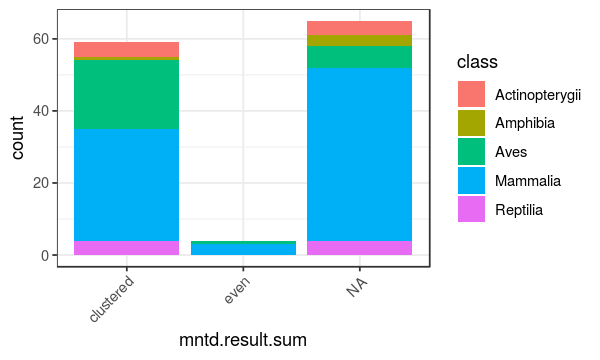

In [48]:
# plotting
p = ggplot(mntd_res_s, aes(mntd.result.sum, fill=class)) +
    geom_bar() +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

options(repr.plot.width=5, repr.plot.height=3)
plot(p)

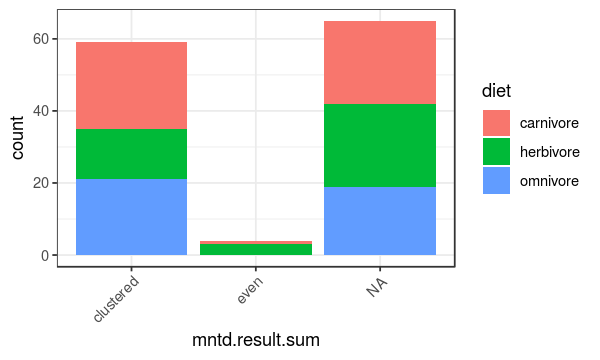

In [49]:
# plotting
p = ggplot(mntd_res_s, aes(mntd.result.sum, fill=diet)) +
    geom_bar() +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

options(repr.plot.width=5, repr.plot.height=3)
plot(p)

Warning message:
“Removed 80 rows containing missing values (geom_linerange).”Warning message:
“Removed 6 rows containing missing values (geom_point).”

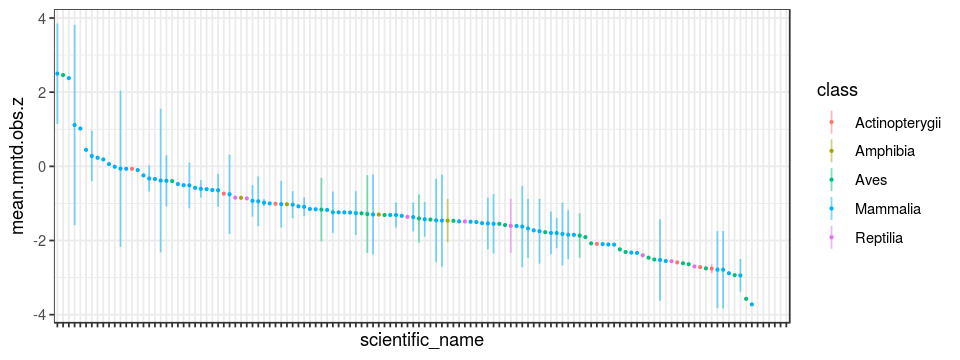

In [50]:
# plotting
p = ggplot(mntd_res_s, aes(scientific_name, mean.mntd.obs.z, color=class)) +
    geom_linerange(aes(ymin=mean.mntd.obs.z-sd.mntd.obs.z,
                       ymax=mean.mntd.obs.z+sd.mntd.obs.z), alpha=0.5) +
    geom_point(size=0.5) +
    theme_bw() +
    theme(
        axis.text.x = element_blank()
    )

options(repr.plot.width=8, repr.plot.height=3)
plot(p)

## Stats

In [51]:
df = inner_join(mpd_res_s, mntd_res_s, 
                c('scientific_name', 'genus', 'family', 'order', 'class', 'diet')) %>%
    dplyr::select(scientific_name, class, diet, mean.mpd.obs.z, mean.mntd.obs.z) %>%
    gather(measure, value, -scientific_name, -class, -diet) 

df %>% dfhead

Warning message:
“Column `scientific_name` joining factors with different levels, coercing to character vector”

[1] 256   5


scientific_name,class,diet,measure,value
Acrocephalus_scirpaceus,Aves,omnivore,mean.mpd.obs.z,-0.7247612
Aepyceros_melampus,Mammalia,herbivore,mean.mpd.obs.z,0.7201200
Anas_platyrhynchos,Aves,omnivore,mean.mpd.obs.z,-1.1917873


In [52]:
tmp = df %>%
    filter(measure == 'mean.mpd.obs.z') 

aov(value ~ class * diet, data=tmp) %>% summary

             Df Sum Sq Mean Sq F value Pr(>F)  
class         4   6.02  1.5059   2.063 0.0905 .
diet          2   1.08  0.5398   0.739 0.4798  
class:diet    4   3.14  0.7848   1.075 0.3724  
Residuals   111  81.05  0.7301                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
6 observations deleted due to missingness

In [53]:
tmp = df %>%
    filter(measure == 'mean.mntd.obs.z') 

aov(value ~ class * diet, data=tmp) %>% summary

             Df Sum Sq Mean Sq F value Pr(>F)  
class         4  11.36   2.840   2.608 0.0395 *
diet          2   2.67   1.337   1.227 0.2970  
class:diet    4   6.27   1.566   1.438 0.2261  
Residuals   111 120.88   1.089                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
6 observations deleted due to missingness

## Summary plots

In [81]:
df = inner_join(mpd_res_s, mntd_res_s, 
                c('scientific_name', 'genus', 'family', 'order', 'class', 'diet')) %>%
    dplyr::select(scientific_name, class, diet, mpd.result.sum, mntd.result.sum) %>%
    gather(measure, value, -scientific_name, -class, -diet) 

df %>% dfhead

Warning message:
“Column `scientific_name` joining factors with different levels, coercing to character vector”

[1] 256   5


scientific_name,class,diet,measure,value
Acrocephalus_scirpaceus,Aves,omnivore,mpd.result.sum,NA
Aepyceros_melampus,Mammalia,herbivore,mpd.result.sum,NA
Anas_platyrhynchos,Aves,omnivore,mpd.result.sum,NA


In [82]:
df_s = df %>%
    mutate(measure = ifelse(measure == 'mntd.result.sum', 'MNTD', 'MPD')) %>%
    group_by(class, diet, measure) %>%
    mutate(total_count = n()) %>%
    group_by(class, diet, measure, value) %>%
    summarize(n = n() / first(total_count)) %>%
    ungroup() %>%
    mutate(value = factor(value, levels=c('NA', 'even', 'clustered')))

df_s %>% dfhead

[1] 43  5


class,diet,measure,value,n
Actinopterygii,carnivore,MNTD,clustered,0.4
Actinopterygii,carnivore,MNTD,NA,0.6
Actinopterygii,carnivore,MPD,clustered,0.2


File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/16S/5_assembly/relatedness/.figures/IndD_mpd-mntd_cat-frac.pdf 


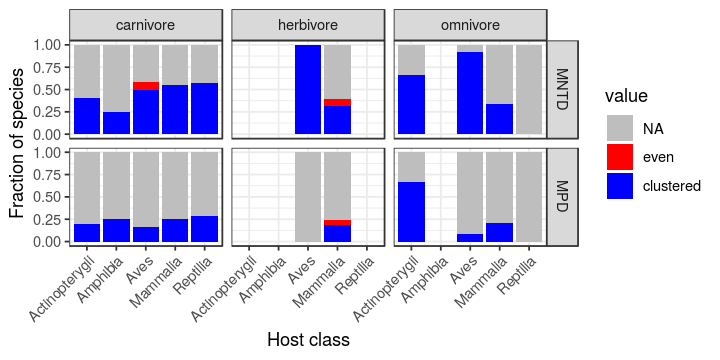

In [85]:
p = ggplot(df_s, aes(class, n, fill=value)) +
    geom_bar(stat='identity') +
    labs(x='Host class', y='Fraction of species') +
    scale_fill_manual(values=c('grey', 'red', 'blue')) +
    facet_grid(measure ~ diet) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

options(repr.plot.width=6, repr.plot.height=3)
plot_write(p, file='IndD_mpd-mntd_cat-frac.pdf')

File written: /ebio/abt3_projects/Georg_animal_feces/notebooks/16S/5_assembly/relatedness/.figures/IndD_mpd-mntd_cat-frac.pdf 


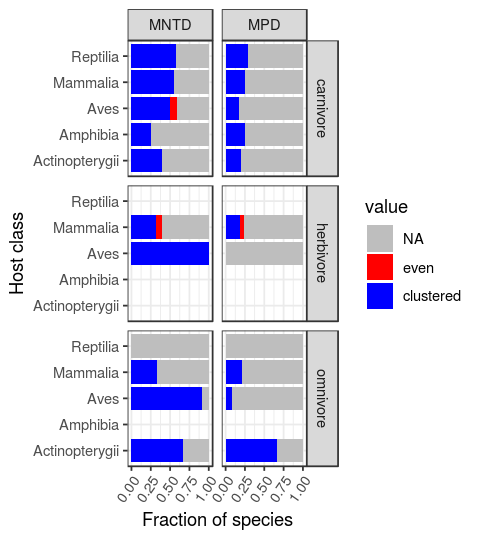

In [83]:
p = ggplot(df_s, aes(class, n, fill=value)) +
    geom_bar(stat='identity') +
    labs(x='Host class', y='Fraction of species') +
    scale_fill_manual(values=c('grey', 'red', 'blue')) +
    facet_grid(diet ~ measure) +
    coord_flip() +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=55, hjust=1)
    )

options(repr.plot.width=4, repr.plot.height=4.5)
plot_write(p, file='IndD_mpd-mntd_cat-frac.pdf')

In [68]:
df = inner_join(mpd_res_s, mntd_res_s, 
                c('scientific_name', 'genus', 'family', 'order', 'class')) 

df %>% dfhead

Warning message:
“Column `scientific_name` joining factors with different levels, coercing to character vector”

[1] 128  13


scientific_name,class,order,family,genus,diet.x,mpd.result.sum,mean.mpd.obs.z,sd.mpd.obs.z,diet.y,mntd.result.sum,mean.mntd.obs.z,sd.mntd.obs.z
Acrocephalus_scirpaceus,Aves,Passeriformes,Sylviidae,Acrocephalus,omnivore,NA,-0.7247612,NA,omnivore,clustered,-2.612958,NA
Aepyceros_melampus,Mammalia,Artiodactyla,Bovidae,Aepyceros,herbivore,NA,0.7201200,NA,herbivore,NA,-1.078168,NA
Anas_platyrhynchos,Aves,Anseriformes,Anatidae,Anas,omnivore,NA,-1.1917873,NA,omnivore,clustered,-2.638899,NA


Warning message:
“Removed 6 rows containing non-finite values (stat_boxplot).”

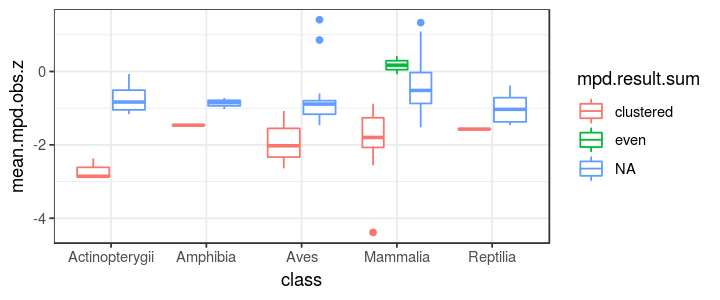

In [70]:
p = ggplot(df, aes(class, mean.mpd.obs.z, color=mpd.result.sum)) +
    geom_boxplot() +
    theme_bw()

options(repr.plot.width=6, repr.plot.height=2.5)
plot(p)

Warning message:
“Removed 6 rows containing non-finite values (stat_boxplot).”

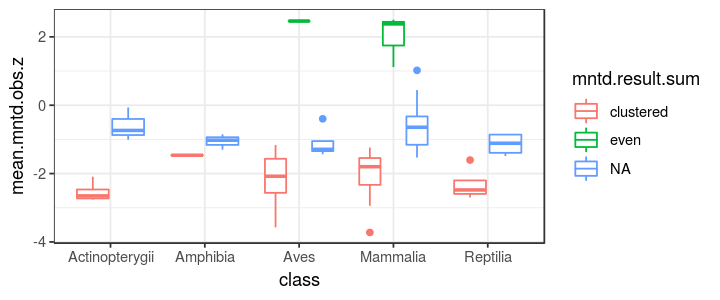

In [71]:
p = ggplot(df, aes(class, mean.mntd.obs.z, color=mntd.result.sum)) +
    geom_boxplot() +
    theme_bw()

options(repr.plot.width=6, repr.plot.height=2.5)
plot(p)

## iTOL plotting

### Heatmap of obs.z

In [72]:
df = inner_join(mpd_res_s, mntd_res_s, 
                c('scientific_name', 'genus', 'family', 'order', 'class')) %>%
    dplyr::select(scientific_name, mean.mpd.obs.z, mean.mntd.obs.z) %>%
    as.data.frame

rownames(df) = df$scientific_name
df$scientific_name = NULL

df %>% dfhead

Warning message:
“Column `scientific_name` joining factors with different levels, coercing to character vector”

[1] 128   2


,mean.mpd.obs.z,mean.mntd.obs.z
Acrocephalus_scirpaceus,-0.7247612,-2.612958
Aepyceros_melampus,0.7201200,-1.078168
Anas_platyrhynchos,-1.1917873,-2.638899


In [73]:
htmp_file = file.path(work_dir, 'IndD_16S_mpd-mntd_obsZ_itol-htmp.txt')
itol_heatmap(df, 'mpd-mntd', htmp_file, dist_method=NULL)

Warning message in if (color_scheme == "color") {:
“the condition has length > 1 and only the first element will be used”

File written: /ebio/abt3_projects/Georg_animal_feces/data/assembly/relatedness//IndD_16S_mpd-mntd_obsZ_itol-htmp.txt 


### Color strip of clustered/even

#### mpd

In [74]:
df = inner_join(mpd_res_s, mntd_res_s, 
                c('scientific_name', 'genus', 'family', 'order', 'class')) %>%
    dplyr::select(scientific_name, mpd.result.sum) %>%
    mutate(mpd.result.sum = mpd.result.sum %>% as.character) %>%
    as.data.frame

rownames(df) = df$scientific_name
df$scientific_name = NULL

df %>% dfhead

Warning message:
“Column `scientific_name` joining factors with different levels, coercing to character vector”

[1] 128   1


,mpd.result.sum
Acrocephalus_scirpaceus,NA
Aepyceros_melampus,NA
Anas_platyrhynchos,NA


In [75]:
# setting colors
x = df$mpd.result.sum %>% unique %>% sort
cols = c('#0000FF', '#FF3300', '#A6ACAF')
legend = data.frame(labels = x,
                    colors = cols,
                    shapes = rep(1, length(labels)))
legend

labels,colors,shapes
clustered,#0000FF,1
even,#FF3300,1
NA,#A6ACAF,1


In [76]:
clr_file = file.path(work_dir, 'IndD_16S_mpd_ID_itol-clr.txt')
itol_colorstrip(df, 'mpd-ID', clr_file, legend=legend)

File written: /ebio/abt3_projects/Georg_animal_feces/data/assembly/relatedness//IndD_16S_mpd_ID_itol-clr.txt 


#### mntd

In [77]:
df = inner_join(mpd_res_s, mntd_res_s, 
                c('scientific_name', 'genus', 'family', 'order', 'class')) %>%
    dplyr::select(scientific_name, mntd.result.sum) %>%
    mutate(mntd.result.sum = mntd.result.sum %>% as.character) %>%
    as.data.frame

rownames(df) = df$scientific_name
df$scientific_name = NULL

df %>% dfhead

Warning message:
“Column `scientific_name` joining factors with different levels, coercing to character vector”

[1] 128   1


,mntd.result.sum
Acrocephalus_scirpaceus,clustered
Aepyceros_melampus,NA
Anas_platyrhynchos,clustered


In [78]:
# setting colors
x = df$mntd.result.sum %>% unique %>% sort
cols = c('#0000FF', '#FF3300', '#A6ACAF')
legend = data.frame(labels = x,
                    colors = cols,
                    shapes = rep(1, length(labels)))
legend

labels,colors,shapes
clustered,#0000FF,1
even,#FF3300,1
NA,#A6ACAF,1


In [79]:
clr_file = file.path(work_dir, 'IndD_16S_mntd_ID_itol-clr.txt')
itol_colorstrip(df, 'mntd-ID', clr_file, legend=legend)

File written: /ebio/abt3_projects/Georg_animal_feces/data/assembly/relatedness//IndD_16S_mntd_ID_itol-clr.txt 


# sessionInfo

In [80]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq_phylo/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq_phylo/lib/R/lib/libRlapack.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2.2          future.apply_1.0.0      future.batchtools_0.7.1
 [4] future_1.9.0            picante_1.7             nlme_3.1-131           
 [7] vegan_2.4-3             lattice_0.20-34         permute_0.9-4          
[10] phyloseq_1.22.3         ape_5.1                 ggplot2_3.0.0          
[13] tidyr_0.8.1             dplyr_0.7.6            

loaded via a namespace (and not attached):
 [1] Biobase_2.38.0      jsonlite_1.5        splines_3.4.1      
 [4] foreach_1.4.4       assertthat_0.2.0    stats4_3.4.